In [3]:
! pip install wand

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 3.2 MB/s eta 0:00:00 MB/s eta 0:00:01


In [3]:
! brew uninstall imagemagick
! brew install imagemagick@6
! brew unlink imagemagick
! brew link imagemagick@6 --force
! echo 'export MAGICK_HOME="/usr/local/opt/imagemagick@6/lib"' >> ~/.bash_profile
! echo 'export PATH="/usr/local/opt/imagemagick@6/bin:$PATH"' >> ~/.bash_profile

! source ~/.bash_profile

Uninstalling /opt/homebrew/Cellar/imagemagick/7.1.0-51... (805 files, 30.8MB)
==> Downloading https://ghcr.io/v2/homebrew/core/imagemagick/6/manifests/6.9.12-
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/imagemagick/6/blobs/sha256:3681
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring imagemagick@6--6.9.12-66.arm64_monterey.bottle.tar.gz
==> Caveats
imagemagick@6 is keg-only, which means it was not symlinked into /opt/homebrew,
because this is an alternate version of another formula.

If you need to have imagemagick@6 first in your PATH, run:
  echo 'export PATH="/opt/homebrew/opt/imagemagick@6/bin:$PATH"' >> ~/.zshrc

For compilers to find imagemagick@6 you may need to set:
  export LDFLAGS="-L/opt/homebrew/opt/imagemagick@6/lib"
  export CPPFLAGS="-I/opt/homebrew/opt/imagemagick@6

In [ ]:
! convert -list font

In [2175]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from wand.color import Color
from wand.image import Image
from wand.drawing import Drawing
from wand.compat import nested
import shutil

In [2176]:
# Charatcters 
language = 'abcdefghijklmnopqrstuvwxyz'
language_upper = language.upper()
language += language_upper
language += '0123456789'

assert len(language) == 26 * 2 + 10 
language = language_upper
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [2306]:
# Fonts
handwritten_fonts = ['Herculanum', 'Annai MN', 'Bradley Hand', 'Brush Script MT', 'Chalkboard',
             'Comic Sans MS', 'Luminary', 'Noteworthy', 'Papyrus', 'Party LET', 'Savoye LET', 
             'Sign Painter', 'Skia', 'Snell Roundhand', 'Times New Roman', 'Trattatello', 'Zapfino']
typed_fonts = ['Arial', 'Arial Black', 'Arial Narrow', 'Arial Rounded MT Bold', 'Copperplate', 'Courier New', 'Helvetica',
              'Impact', 'Lucinda Grande', 'Microsoft Sans Serif', 'Tahoma', 'Verdana', 'Menlo', 'Didot', 'Copperplate', 'Avenir', 'Futura']

# fonts = handwritten_fonts + typed_fonts 
fonts = ['Chalkboard']

In [2307]:
# resolution
width=200
height=200
font_size=100
background = Color('white')
foreground=Color('rgb(0, 0, 0)')

In [2308]:
language

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [2309]:
def delete(language, language_upper):
    for c in language:
        if c in language_upper:
            if os.path.exists(f'{c}{c}'):
                shutil.rmtree(f'{c}{c}')
        else:
            if os.path.exists(c):
                shutil.rmtree(f'{c}')

In [2310]:
def generate(fonts, language, language_upper, width=200, height=200, font_size=100, background=Color('white'), foreground=Color('rgb(0,0,0)')):
    for f in tqdm(fonts):
        for c in language:
            if c in language_upper:
                if not os.path.exists(f'{c}{c}'):
                    os.mkdir(f'{c}{c}')
                filename = os.path.join(f'{c}{c}', f'{f}.png')
            else:
                if not os.path.exists(c):
                    os.mkdir(f'{c}')
                filename = os.path.join(f'{c}', f'{f}.png')

            with Drawing() as draw:
                with Image(width=width, height=height, background=background) as img:
                    draw.font_family = f
                    draw.font_size = font_size
                    draw.push()
                    draw.fill_color = foreground
                    draw.text(0,int(img.height/2), c)
                    draw.pop()
                    draw(img)
                    if os.path.exists(filename):
                        os.unlink(filename)
                    img.save(filename='tmp.png')

                    img = cv2.imread('tmp.png')

                    os.unlink('tmp.png')
                    ys, xs = np.where(np.all(img == (0, 0, 0), axis=-1))

                    cropped = img[min(ys):max(ys)+1, min(xs):max(xs)+1]
                    cv2.imwrite(filename, cropped)
            

In [2311]:
generate(fonts, language, language_upper)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.47it/s]


#### Inference

##### Functions

In [2295]:
import matplotlib.pyplot as plt
def show(*img):
    for i in img:
        plt.imshow(i, cmap='gray')
        plt.show()

# Read
def read(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def bin(img, bins=10, min_diff=10):
    count, division = np.histogram(img, bins)
    diff_series = pd.Series(count).diff()
    
    first_histogram_reduction_index = diff_series[(diff_series < 0) & (np.abs(diff_series) > min_diff)].index[0]
    threshold = division[first_histogram_reduction_index+1]
        
    _, img = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
    return img

def bin2(img):
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY +cv2.THRESH_OTSU)[1]

def neg(img):
    return 255 - img

def redraw_contours(img, thickness=16): 
    # Find contours and redraw
    contours, hierarchy = cv2.findContours(image=img, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                      
    # draw contours on the original image
    image_copy = img.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(255, 255, 255), thickness=thickness, lineType=cv2.LINE_AA)
    return image_copy

def components(img, min_area=1000):
    # Connected components
    output = cv2.connectedComponentsWithStats(img, 4, cv2.CV_32S)
    num_letters = output[0]
    letters = output[1]
    stats = output[2]
    centroids = output[3]

    letter_imgs = []
    ## Sort letters + area check
    image_copy = img.copy()
    for l in range(1, num_letters):
        minx = stats[l, cv2.CC_STAT_LEFT]
        maxx = stats[l, cv2.CC_STAT_WIDTH] + minx
        miny = stats[l, cv2.CC_STAT_TOP] 
        maxy = stats[l, cv2.CC_STAT_HEIGHT] + miny
        area = stats[l, cv2.CC_STAT_AREA]
        if area < min_area:
            continue

        cropped_img = img[miny:maxy+1, minx: maxx+1].copy()
        letter_imgs.append((cropped_img, minx))
        cv2.rectangle(image_copy,(minx, miny), (maxx, maxy) ,(255, 255, 255), 3)

    sorted_img_list = sorted(letter_imgs, 
       key=lambda x: x[1])
    return [s[0] for s in sorted_img_list]

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def resize(img, size=(100, 100)):
    return cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)

In [2218]:
def pipeline(x, show_steps=False):
    img = read(x)
    img_bin = bin(img)
    
    # # Denoise
    # img_bin = bin(cv2.blur(img_bin,(2,2)))
    
    # Neg
    img_bin_neg = neg(img_bin)
    
    # Adaptive thickening
#     thickness = 4
#     redraw = redraw_contours(img_bin_neg, thickness=thickness)
#     letter_boxes = components(redraw)
#     n_letters = len(letter_boxes)
    
#     tmp_letters = n_letters
#     # print(n_letters)
#     while True:
#         thickness *= 2
#         redraw = redraw_contours(img_bin_neg, thickness=thickness)
#         letter_boxes = components(redraw)
#         tmp_letters = len(letter_boxes)
#         print(tmp_letters)
        
#         if tmp_letters < n_letters:
#             break
#         elif tmp_letters >= n_letters:
#             n_letters = tmp_letters
        
#     thickness//=2
#     redraw = redraw_contours(img_bin_neg, thickness=thickness)

    # Redraw contours to make stronger letters
    redraw = redraw_contours(img_bin_neg)
    
    # Find components
    letter_boxes = components(redraw)

    letter_boxes = [neg(l) for l in letter_boxes]
    if show_steps:
        show(img)
        show(img_bin)
        show(img_bin_neg)
        show(redraw)
        for l in letter_boxes:
            show(l)
            
    return letter_boxes

In [2219]:
def classify(letter_img, inference_size=(500, 500), _filter='.png'):
    results = []
    for c in language:
        if c in language_upper:
            fld = f'{c}{c}'
        else:
            fld = f'{c}'
            
        files = [x for x in os.listdir(fld) if x.endswith(_filter)]
        letter_img_r = bin(cv2.resize(letter_img, inference_size, interpolation=cv2.INTER_NEAREST))
        for f in files: 
            ## TODO Check and possibly binarize all when reading
            path = os.path.join(fld, f)
            img_f = bin(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
            img_fr = bin(cv2.resize(img_f, inference_size, interpolation=cv2.INTER_NEAREST))
            
            iou = (letter_img_r//255 & img_fr//255).sum() / (letter_img_r//255 | img_fr//255).sum()
            results.append( {
                'char': c,
                'font': f,
                'iou': iou
            })
    results = pd.DataFrame(results)
    
    # selection
    g = results.groupby('char')['iou'].mean()
    character = g[g == g.max()].index[0]
    return character, results

In [2220]:
def ocr(path, show_steps=False, return_dfs=False):
    letters = pipeline(path, show_steps=show_steps)
    if return_dfs==False:
        return [classify(l)[0] for l in letters]
    else:
        return [classify(l) for l in letters]

##### Best font search

In [2222]:
expectations = {
    'test.png' : "TEST",
    'tactical.png': "TACTICAL",
    'digital.png': "DIGITAL",
    'ocr.png': "OCR",
    'team.png': "TEAM",
    'processing.png': "PROCESSING",
}

In [2167]:
test_fonts = handwritten_fonts + typed_fonts
font_results = {}
for f in tqdm(test_fonts):
    count = 0
    delete(language, language_upper)
    generate([f], language, language_upper)
    for path, exp_result in expectations.items():
        res = ''.join(ocr(path))
        for i in range(len(exp_result)):
            if res[i] == exp_result[i]:
                count+=1
    font_results[f] = count
font_results

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [1:08:36<00:00, 121.08s/it]


{'Herculanum': 23,
 'Annai MN': 21,
 'Bradley Hand': 24,
 'Brush Script MT': 16,
 'Chalkboard': 28,
 'Comic Sans MS': 28,
 'Luminary': 21,
 'Noteworthy': 15,
 'Papyrus': 19,
 'Party LET': 9,
 'Savoye LET': 3,
 'Sign Painter': 21,
 'Skia': 22,
 'Snell Roundhand': 3,
 'Times New Roman': 23,
 'Trattatello': 26,
 'Zapfino': 4,
 'Arial': 21,
 'Arial Black': 26,
 'Arial Narrow': 20,
 'Arial Rounded MT Bold': 23,
 'Copperplate': 27,
 'Courier New': 9,
 'Helvetica': 19,
 'Impact': 21,
 'Lucinda Grande': 21,
 'Microsoft Sans Serif': 19,
 'Tahoma': 28,
 'Verdana': 26,
 'Menlo': 20,
 'Didot': 18,
 'Avenir': 21,
 'Futura': 25}

In [2174]:
pd.DataFrame([font_results]).T.sort_values(by=0)

0
Savoye LET              3
Snell Roundhand         3
Zapfino                 4
Courier New             9
Party LET               9
Noteworthy             15
Brush Script MT        16
Didot                  18
Microsoft Sans Serif   19
Papyrus                19
Helvetica              19
Menlo                  20
Arial Narrow           20
Annai MN               21
Lucinda Grande         21
Impact                 21
Avenir                 21
Arial                  21
Luminary               21
Sign Painter           21
Skia                   22
Herculanum             23
Arial Rounded MT Bold  23
Times New Roman        23
Bradley Hand           24
Futura                 25
Arial Black            26
Trattatello            26
Verdana                26
Copperplate            27
Comic Sans MS          28
Tahoma                 28
Chalkboard             28

### Debug

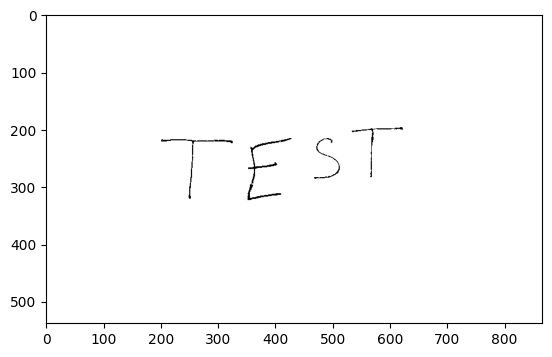

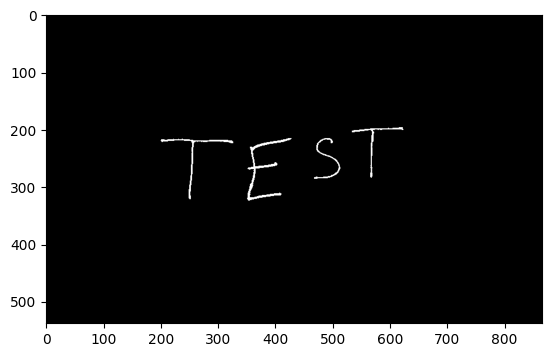

In [2304]:
x = cv2.imread('test.png', cv2.IMREAD_UNCHANGED)
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
     
f = 131 * (contrast + 127)/(127*(131-contrast)) 
new_image = (f * (x - 127) + 127).astype(np.uint8)
contrast=-50
show(bin(gray(x)))
show(bin(gray(new_image)))

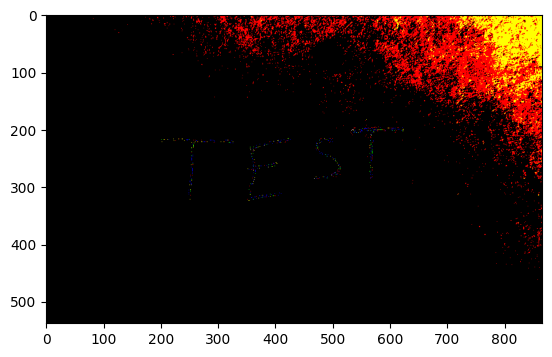

In [2294]:
show(bin(new_image))

### Tests

In [2223]:
"".join(ocr('test.png'))


'TFST'

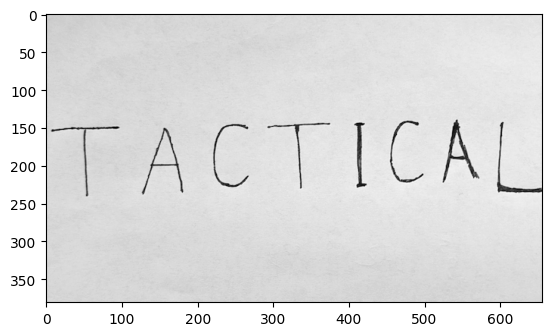

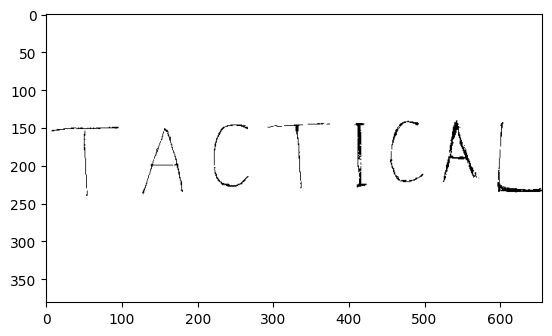

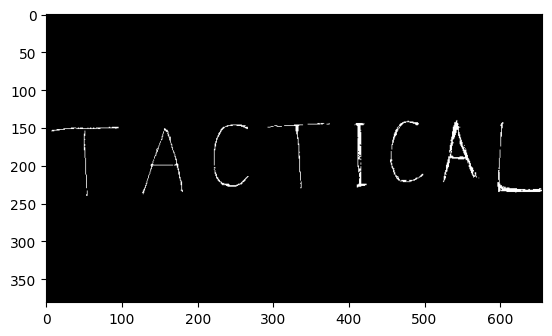

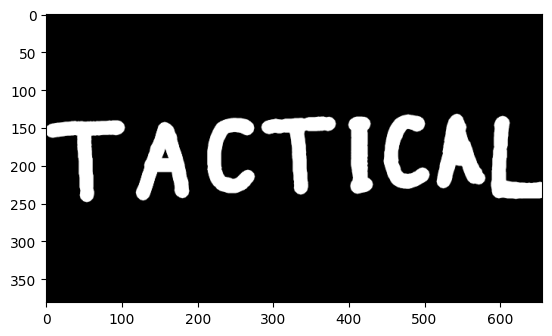

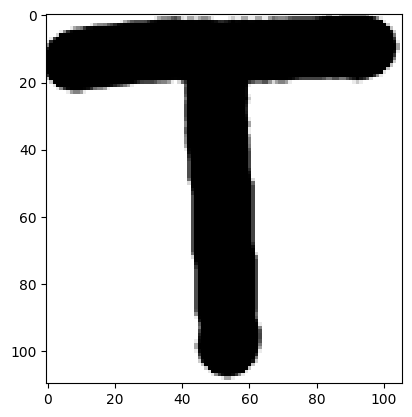

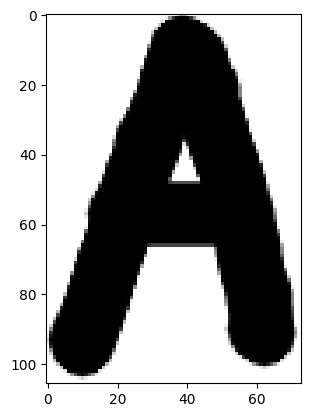

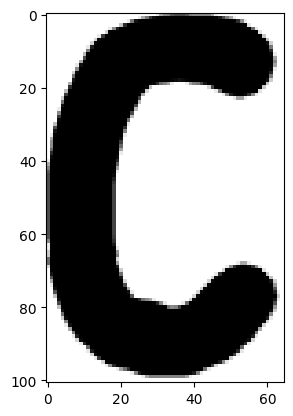

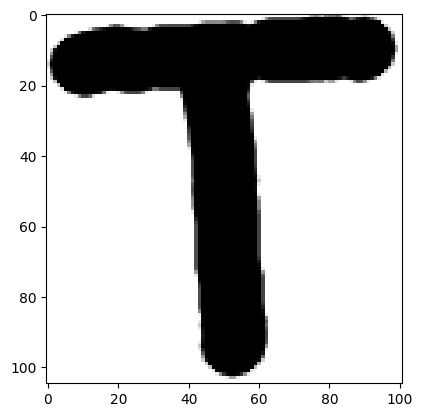

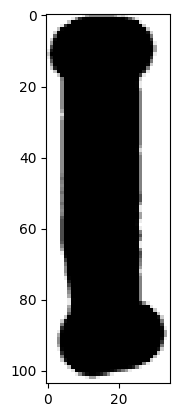

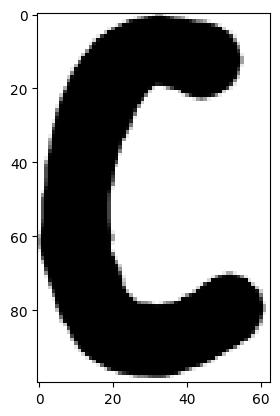

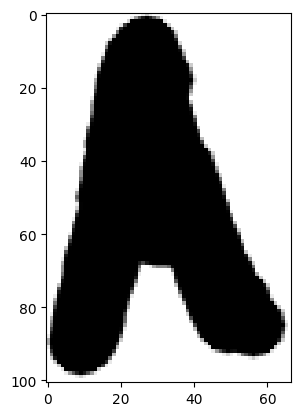

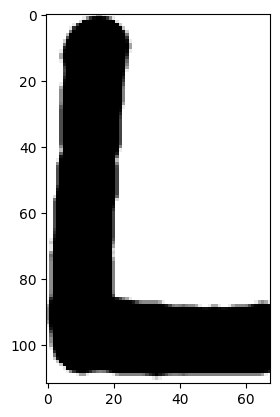

['T', 'A', 'C', 'T', 'I', 'C', 'A', 'L']

In [2312]:
ocr('tactical.png', show_steps=True)

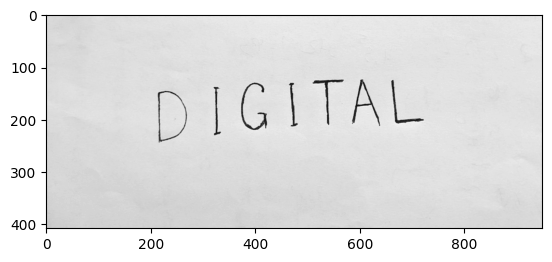

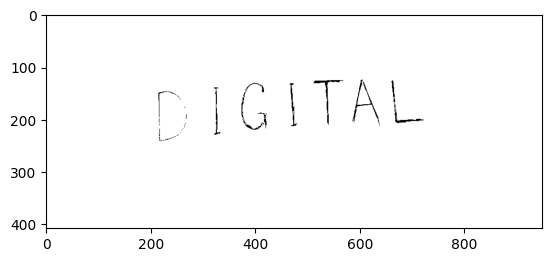

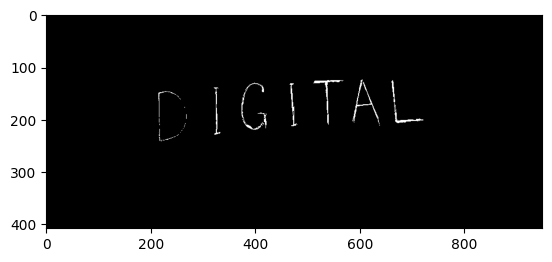

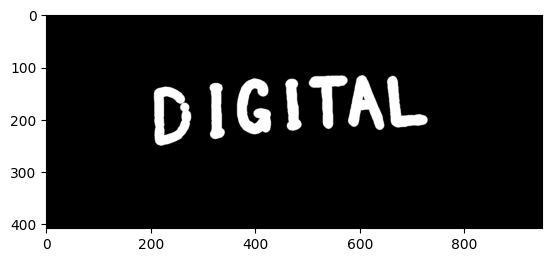

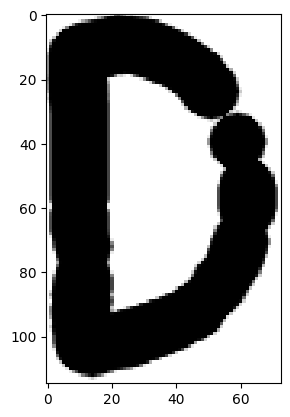

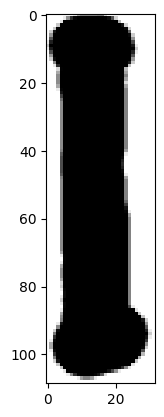

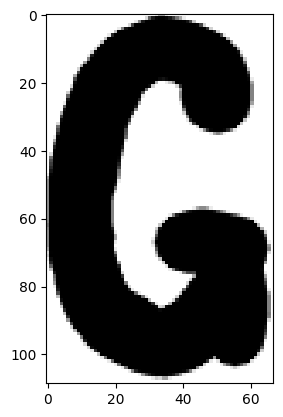

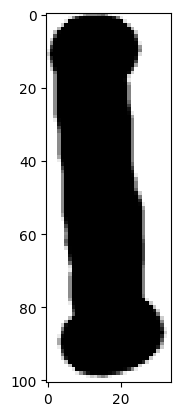

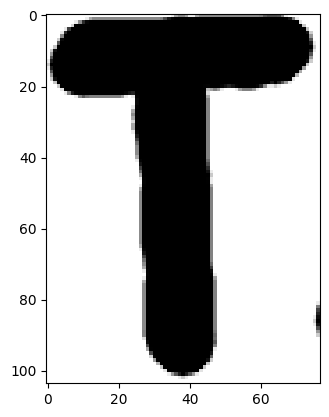

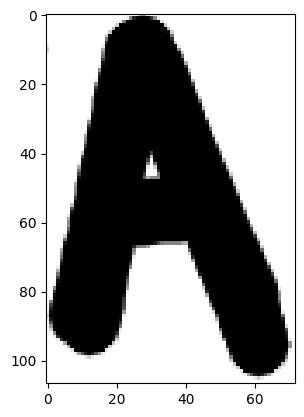

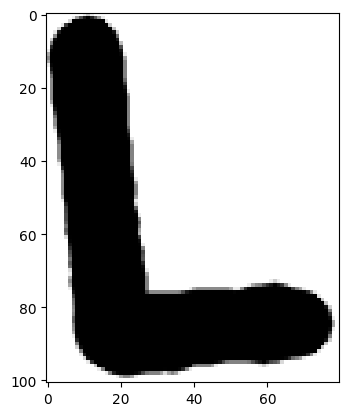

['D', 'I', 'C', 'I', 'T', 'A', 'L']

In [2314]:
ocr('digital.png', show_steps=True)

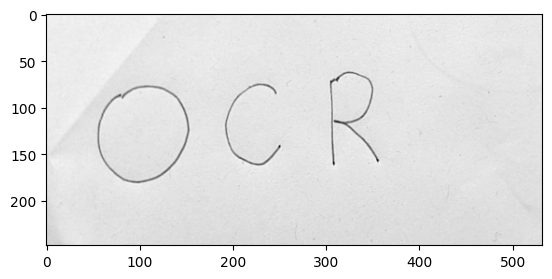

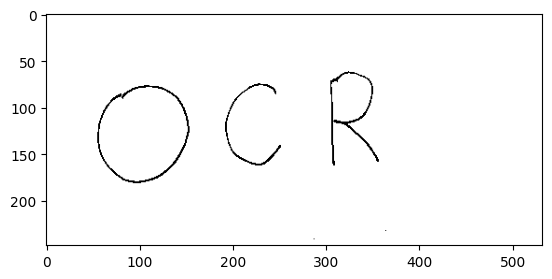

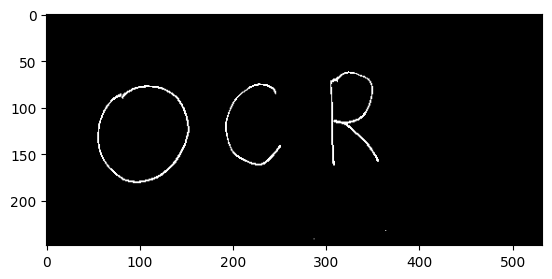

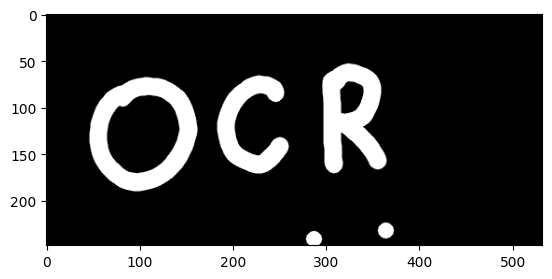

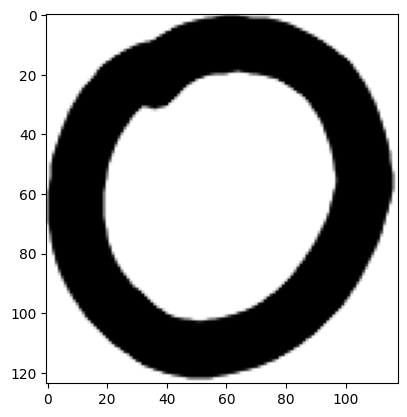

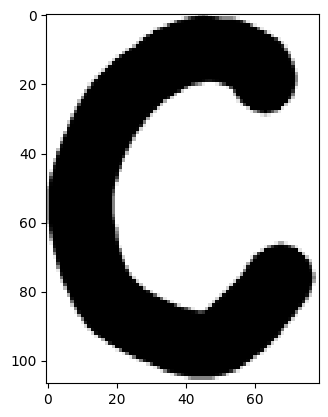

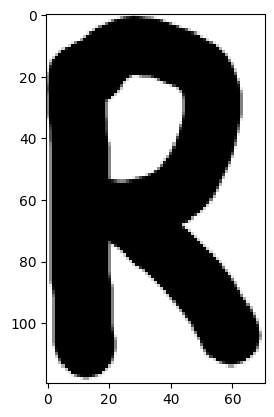

['O', 'C', 'R']

In [2315]:
ocr('ocr.png', show_steps=True)

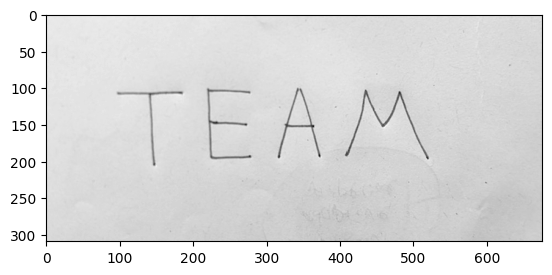

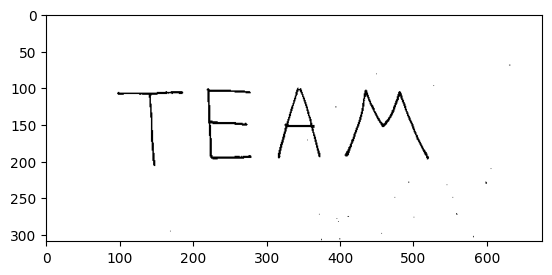

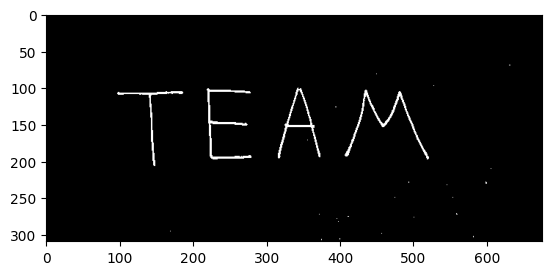

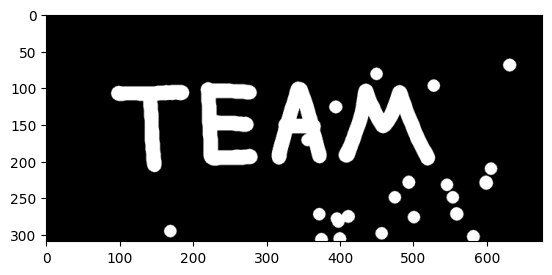

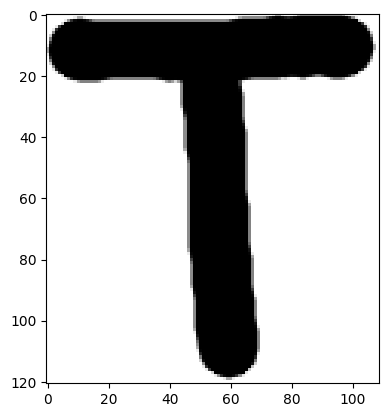

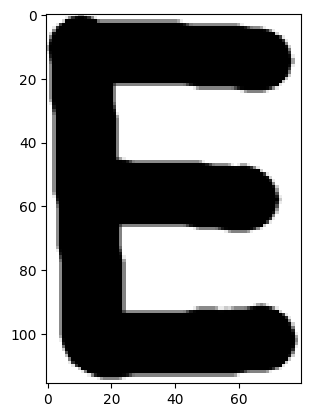

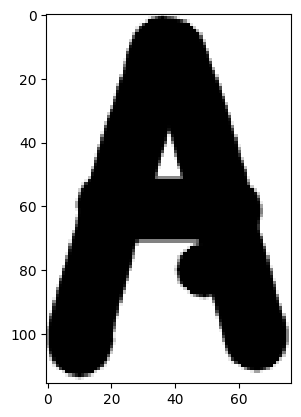

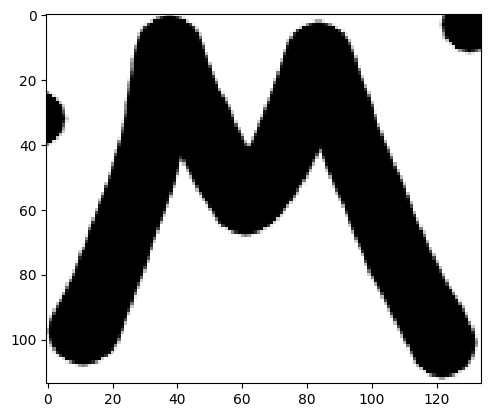

['T', 'E', 'A', 'A']

In [2316]:
ocr('team.png', show_steps=True)

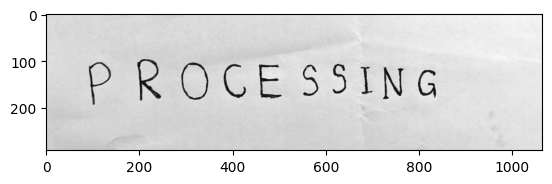

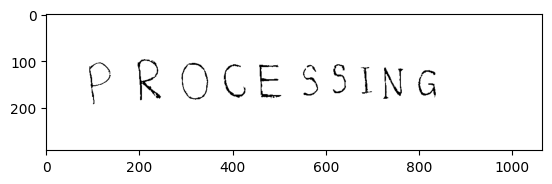

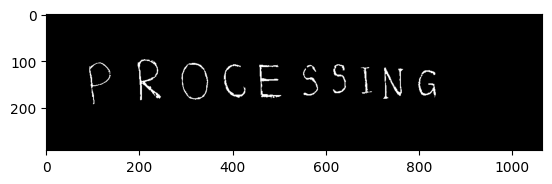

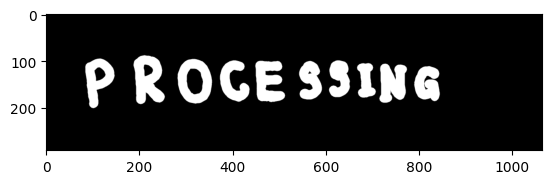

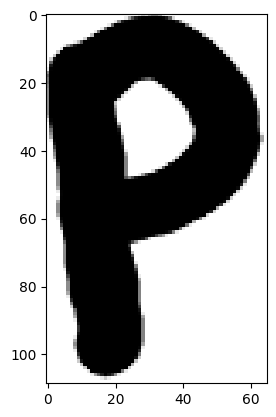

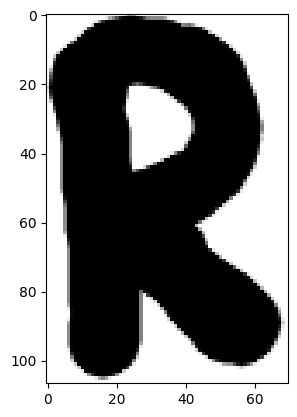

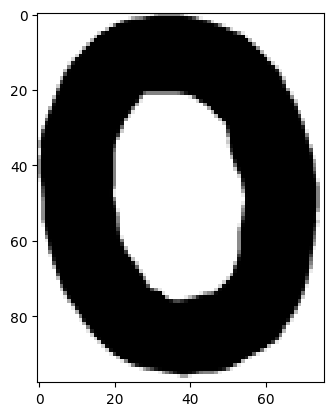

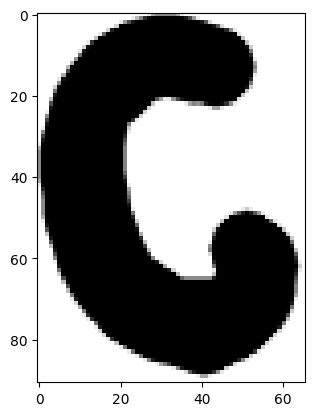

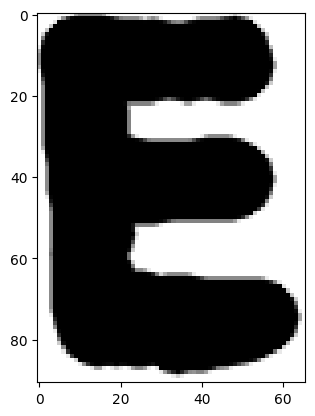

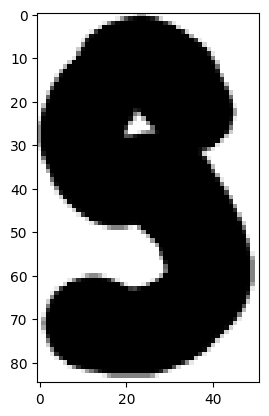

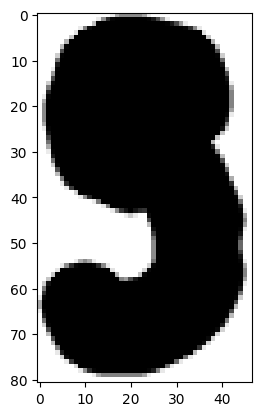

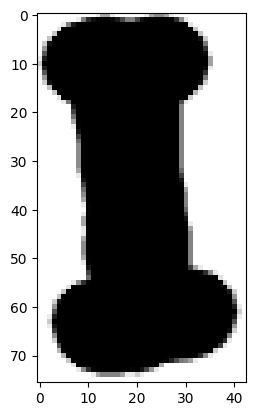

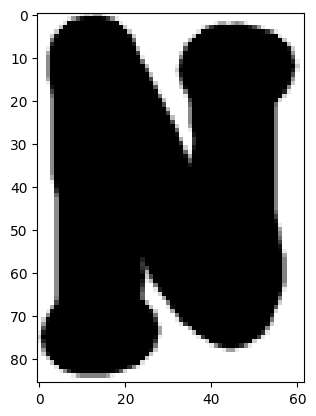

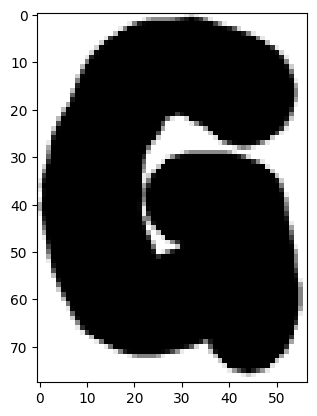

['F', 'R', 'D', 'C', 'F', 'S', 'S', 'I', 'X', 'A']

In [2317]:
ocr('processing.png', show_steps=True)